In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
from netCDF4 import date2num,num2date
import cftime
from math import sqrt
import matplotlib.pyplot as plt 
import sys

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from MWDC import preprocessing



import dask.dataframe

#### Reading .nc Data

In [2]:
path = ('../../data/ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path, decode_times=False) 
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

## Preprocessing 

#### Transforming only sst data
- To evaluate the performance of KernelPCA, first applying it to single variable which is 'sst'. This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and, pairs of both dimensions "latitude" and "longitude" will become the columns for each variable.

In [3]:
preprocessing.null_fill(data)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float64 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float64 33.0 33.25 33.5 33.75 ... 42.5 42.75 43.0
Data variables:
    sst        (time, longitude, latitude) float64 294.0 293.8 ... 289.4 289.2
    sp         (time, longitude, latitude) float64 1.015e+05 ... 9.893e+04
    u10        (time, longitude, latitude) float64 -2.685 -2.525 ... 6.352 6.21
    v10        (time, longitude, latitude) float64 5.305 4.99 ... 11.29 10.92
    sshf       (time, longitude, latitude) float64 -4.078e+04 ... -2.794e+04
    slhf       (time, longitude, latitude) float64 -3.481e+05 ... -6.7e+05
    t2m        (time, longitude, latitude) float64 292.6 292.5 ... 288.7 288.7

In [4]:
sst1= preprocessing.ssttransform(data)
sst1

array([[-0.4518424 , -0.43652493, -0.46894147, ..., -0.86961173,
        -0.87607272, -0.89986274],
       [-0.47091546, -0.49167752, -0.53004918, ..., -0.88337155,
        -0.87899358, -0.89258421],
       [-0.57560226, -0.56533429, -0.58092795, ..., -0.9183021 ,
        -0.91494534, -0.92796648],
       ...,
       [-0.7528017 , -0.72755649, -0.67003587, ..., -0.43742492,
        -0.48411092, -0.54468652],
       [-0.77699902, -0.70408783, -0.64958739, ..., -0.46643138,
        -0.48504963, -0.50973757],
       [-0.76242161, -0.727292  , -0.68689623, ..., -0.49276713,
        -0.51989564, -0.5771943 ]])

In [5]:
sst1.shape

(365, 1681)

In [15]:
data = data.drop('t2m')
data = data.drop('slhf')
data = data.drop('sshf')
data = data.drop('v10')
data = data.drop('u10')
data = data.drop('sp')

data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sst        (time, latitude, longitude) float64 290.1 290.0 ... 293.4 293.3
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [16]:
data.to_netcdf('single_var_ERA5_meteo_sfc_2021_daily.nc')

In [17]:
tf_sst_data = preprocessing.datatransformation(data)
tf_sst_data

,"sst(43.0,-33.0)","sst(42.75,-33.0)","sst(42.5,-33.0)","sst(42.25,-33.0)","sst(42.0,-33.0)","sst(41.75,-33.0)","sst(41.5,-33.0)","sst(41.25,-33.0)","sst(41.0,-33.0)","sst(40.75,-33.0)",...,"sst(35.25,-23.0)","sst(35.0,-23.0)","sst(34.75,-23.0)","sst(34.5,-23.0)","sst(34.25,-23.0)","sst(34.0,-23.0)","sst(33.75,-23.0)","sst(33.5,-23.0)","sst(33.25,-23.0)","sst(33.0,-23.0)"
0.0,290.120809,290.198989,290.163838,289.908009,289.776023,289.416485,289.279786,289.298749,289.412232,289.612776,...,292.574080,292.498104,292.416313,292.350892,292.321388,292.353764,292.406358,292.468126,292.535987,292.600670
1.0,290.079384,290.077223,290.026065,289.839130,289.695864,289.328392,289.194537,289.201049,289.294831,289.487051,...,292.453081,292.446389,292.388831,292.292610,292.249929,292.284439,292.348647,292.434885,292.529030,292.617443
2.0,289.852013,289.914604,289.911355,289.774294,289.640830,289.323623,289.225770,289.269552,289.370277,289.552165,...,292.283477,292.329824,292.275278,292.176198,292.131204,292.163175,292.246123,292.350501,292.443391,292.535904
3.0,289.723889,289.820934,289.819498,289.687540,289.494497,289.156347,289.109373,289.139239,289.313556,289.628588,...,292.221876,292.467317,292.448424,292.259843,292.151310,292.011446,292.083685,292.356901,292.505577,292.577510
4.0,289.885672,290.112513,290.180598,290.013991,289.699503,289.233230,289.169244,289.194356,289.440634,289.745181,...,292.065796,292.313719,292.325013,292.150905,292.053275,291.947377,292.027871,292.276171,292.448090,292.559649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,289.489953,289.579523,289.676942,289.729824,289.775556,289.700285,289.696682,289.980434,290.145347,290.183858,...,292.046897,292.095863,292.210913,292.492743,292.851638,293.121902,293.358725,293.522129,293.513968,293.536428
361.0,289.552235,289.658312,289.777707,289.838365,289.739096,289.638772,289.630882,289.779872,289.968499,290.342562,...,292.012217,291.971526,292.138619,292.510788,292.859457,293.116775,293.344155,293.515763,293.530489,293.515891
362.0,289.467150,289.556451,289.710454,289.841128,289.798871,289.689019,289.597269,289.627577,289.851696,290.304705,...,291.997647,292.015336,292.195190,292.554042,292.955437,293.227510,293.397408,293.512188,293.469660,293.419185
363.0,289.414596,289.608265,289.756557,289.809126,289.658526,289.645622,289.583041,289.649582,289.875481,290.261779,...,291.896725,291.912264,292.118893,292.544243,292.924730,293.182091,293.332932,293.442115,293.467424,293.499726


In [18]:
tf_sst_data.shape

(365, 1681)

### Normalization

In [19]:
tf_sst_data = preprocessing.datanormalization(tf_sst_data)
tf_sst_data

,"sst(43.0,-33.0)","sst(42.75,-33.0)","sst(42.5,-33.0)","sst(42.25,-33.0)","sst(42.0,-33.0)","sst(41.75,-33.0)","sst(41.5,-33.0)","sst(41.25,-33.0)","sst(41.0,-33.0)","sst(40.75,-33.0)",...,"sst(35.25,-23.0)","sst(35.0,-23.0)","sst(34.75,-23.0)","sst(34.5,-23.0)","sst(34.25,-23.0)","sst(34.0,-23.0)","sst(33.75,-23.0)","sst(33.5,-23.0)","sst(33.25,-23.0)","sst(33.0,-23.0)"
0.0,0.277382,0.278881,0.258121,0.238704,0.203745,0.166139,0.140511,0.154529,0.145160,0.146470,...,0.323063,0.297638,0.266496,0.220348,0.182856,0.162071,0.179624,0.188698,0.187435,0.191987
1.0,0.271699,0.262313,0.240006,0.230049,0.193627,0.155130,0.129881,0.142990,0.131470,0.131819,...,0.308363,0.291336,0.263035,0.212799,0.173478,0.152879,0.172126,0.184331,0.186509,0.194223
2.0,0.240507,0.240187,0.224924,0.221902,0.186680,0.154535,0.133776,0.151081,0.140268,0.139407,...,0.287759,0.277129,0.248735,0.197720,0.157897,0.136800,0.158805,0.173245,0.175106,0.183355
3.0,0.222930,0.227442,0.212846,0.211001,0.168209,0.133631,0.119261,0.135690,0.133653,0.148313,...,0.280275,0.293886,0.270540,0.208555,0.160535,0.116681,0.137699,0.174086,0.183386,0.188900
4.0,0.245124,0.267115,0.260324,0.252021,0.194086,0.143239,0.126727,0.142200,0.148472,0.161899,...,0.261313,0.275167,0.254999,0.194444,0.147670,0.108185,0.130448,0.163480,0.175731,0.186520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,0.190837,0.194594,0.194103,0.216314,0.203687,0.201603,0.192497,0.235040,0.230651,0.213018,...,0.259017,0.248616,0.240630,0.238721,0.252444,0.263926,0.303364,0.327171,0.317654,0.316705
361.0,0.199381,0.205315,0.207352,0.229953,0.199084,0.193916,0.184292,0.211353,0.210028,0.231512,...,0.254804,0.233462,0.231525,0.241058,0.253470,0.263246,0.301471,0.326335,0.319854,0.313967
362.0,0.187708,0.191455,0.198509,0.230300,0.206630,0.200195,0.180101,0.193366,0.196408,0.227100,...,0.253034,0.238802,0.238649,0.246661,0.266066,0.277929,0.308390,0.325865,0.311755,0.301078
363.0,0.180499,0.198505,0.204571,0.226279,0.188914,0.194772,0.178327,0.195965,0.199181,0.222098,...,0.240773,0.226240,0.229041,0.245392,0.262036,0.271906,0.300013,0.316659,0.311457,0.311813


### KernelPCA

- Kernel PCA is a non-linear dimensionality reduction technique that uses kernels. It can also be considered as the non-linear form of normal PCA.

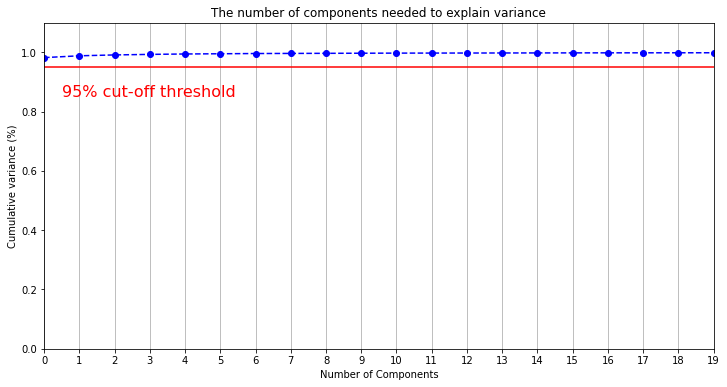

In [20]:
from MWDC import preprocessing
preprocessing.pcacomponents(tf_sst_data)

In [21]:
kpca = KernelPCA(n_components=3, kernel='rbf')
X_kpca = kpca.fit_transform(tf_sst_data)
X_kpca

array([[-0.38682937,  0.01653366, -0.0216515 ],
       [-0.38874364,  0.01865475, -0.02252506],
       [-0.38725131,  0.0165932 , -0.02201044],
       ...,
       [-0.27714136, -0.06933866, -0.0056343 ],
       [-0.28369916, -0.06464253, -0.01048119],
       [-0.28656185, -0.06352876, -0.00844379]])

In [8]:
X_kpca.shape

(365, 3)

In [22]:
distortions = []
inertias = []
K = range(1,50, 2)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_kpca)
    distortions.append(sum(np.min(cdist(X_kpca, km.cluster_centers_,'euclidean'), axis=1)) / X_kpca.shape[0])
    inertias.append(km.inertia_)


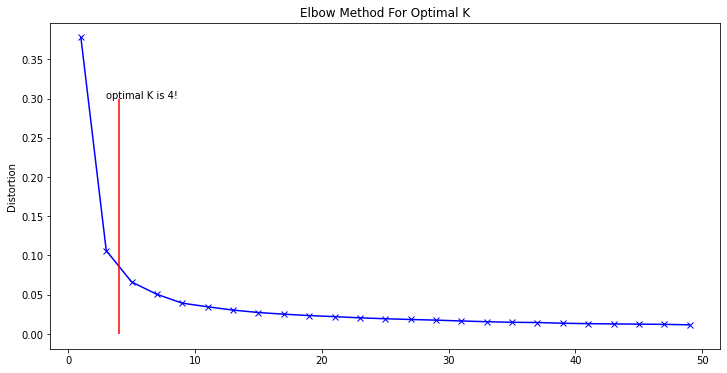

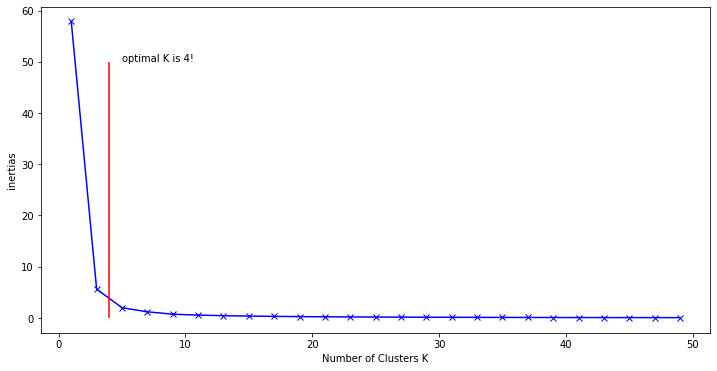

In [26]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=0, ymax=0.3, x=4, colors='red')
plt.text(x=3, y=0.3, s="optimal K is 4!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=0, ymax=50, x=4, colors='red')
plt.text(x=5, y=50, s="optimal K is 4!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_kpca)
P = kmeans.predict(X_kpca)
labels =  kmeans.labels_
frame = pd.DataFrame(X_kpca)
frame['Cluster'] = labels
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [62]:
tf_sst_data.drop('Cluster', axis=1)

,"sst(43.0,-33.0)","sst(42.75,-33.0)","sst(42.5,-33.0)","sst(42.25,-33.0)","sst(42.0,-33.0)","sst(41.75,-33.0)","sst(41.5,-33.0)","sst(41.25,-33.0)","sst(41.0,-33.0)","sst(40.75,-33.0)",...,"sst(35.25,-23.0)","sst(35.0,-23.0)","sst(34.75,-23.0)","sst(34.5,-23.0)","sst(34.25,-23.0)","sst(34.0,-23.0)","sst(33.75,-23.0)","sst(33.5,-23.0)","sst(33.25,-23.0)","sst(33.0,-23.0)"
0.0,0.277382,0.278881,0.258121,0.238704,0.203745,0.166139,0.140511,0.154529,0.145160,0.146470,...,0.323063,0.297638,0.266496,0.220348,0.182856,0.162071,0.179624,0.188698,0.187435,0.191987
1.0,0.271699,0.262313,0.240006,0.230049,0.193627,0.155130,0.129881,0.142990,0.131470,0.131819,...,0.308363,0.291336,0.263035,0.212799,0.173478,0.152879,0.172126,0.184331,0.186509,0.194223
2.0,0.240507,0.240187,0.224924,0.221902,0.186680,0.154535,0.133776,0.151081,0.140268,0.139407,...,0.287759,0.277129,0.248735,0.197720,0.157897,0.136800,0.158805,0.173245,0.175106,0.183355
3.0,0.222930,0.227442,0.212846,0.211001,0.168209,0.133631,0.119261,0.135690,0.133653,0.148313,...,0.280275,0.293886,0.270540,0.208555,0.160535,0.116681,0.137699,0.174086,0.183386,0.188900
4.0,0.245124,0.267115,0.260324,0.252021,0.194086,0.143239,0.126727,0.142200,0.148472,0.161899,...,0.261313,0.275167,0.254999,0.194444,0.147670,0.108185,0.130448,0.163480,0.175731,0.186520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,0.190837,0.194594,0.194103,0.216314,0.203687,0.201603,0.192497,0.235040,0.230651,0.213018,...,0.259017,0.248616,0.240630,0.238721,0.252444,0.263926,0.303364,0.327171,0.317654,0.316705
361.0,0.199381,0.205315,0.207352,0.229953,0.199084,0.193916,0.184292,0.211353,0.210028,0.231512,...,0.254804,0.233462,0.231525,0.241058,0.253470,0.263246,0.301471,0.326335,0.319854,0.313967
362.0,0.187708,0.191455,0.198509,0.230300,0.206630,0.200195,0.180101,0.193366,0.196408,0.227100,...,0.253034,0.238802,0.238649,0.246661,0.266066,0.277929,0.308390,0.325865,0.311755,0.301078
363.0,0.180499,0.198505,0.204571,0.226279,0.188914,0.194772,0.178327,0.195965,0.199181,0.222098,...,0.240773,0.226240,0.229041,0.245392,0.262036,0.271906,0.300013,0.316659,0.311457,0.311813


In [46]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster
def get_datewise_clusters(formed_clusters): # classification
  Dates_Cluster = {}
  for i in set(formed_clusters): # classification
    Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
  return Dates_Cluster

# Non-normalized
# Function that creats a dictionary that holds all the clusters
def n_nor_get_clusters(input,formed_clusters): # classification
  com_arr = []
  Clusters = {}
  Dates_Cluster = get_datewise_clusters(formed_clusters)
  for i in set(formed_clusters):
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input.isel(time=j).to_array()) # input is data
      com_arr.append(arr)
    Clusters['Cluster' + str(i)] = np.array(com_arr)
    com_arr = []
  return Clusters

# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

# Non-normalized
def handle_missing_values(input):
  var_mean = {}
  for i in input.data_vars:
    if input[i].isnull().sum().item() > 0:
      print(i,'has null values')
      var_mean[str(i) + '_mean'] = input[i].mean().item()
      input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
  return input


# Non-normalized 
#Intra RMSE Calculation Function
def n_nor_intra_rmse(input,formed_clusters):
  sq_diff = []
  intra_rmse = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse


###########################  RMSE Computation  #######################################


# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

# Normalized
# Intra RMSE Calculation Function
def nor_intra_rmse(input,formed_clusters):
  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

# RMSE Calculation
def RMSE(input,formed_clusters,frame,normalize=False):
  inter_rmse = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_rmse(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(sum(sum(Sq_diff)))
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          n = len(avg_cluster['avg_cluster'+str(i)][0])
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:

  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(frame,formed_clusters)

    # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = nor_intra_rmse(frame,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(Sq_diff)
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

  return mat


In [53]:
rmse = RMSE(tf_sst_data, labels, frame ,True)
rmse


,0,1,2,3
0,0.06,0.72,0.34,0.94
1,0.72,0.11,0.42,0.29
2,0.34,0.42,0.11,0.68
3,0.94,0.29,0.68,0.07


In [96]:
print("Silhouette Coefficient score for K=4 is ", silhouette_score(tf_sst_data, labels))

Silhouette Coefficient score for K=4 is  0.6302114030428921


In [97]:
print("Davies-Bouldin score for K=3 is ", davies_bouldin_score(tf_sst_data, labels))

Davies-Bouldin score for K=3 is  0.5043726727235617


In [93]:

def pearson_PM(x, y):

    #convert format from netcdf to np array
    #x_form = x.to_numpy()
    #y_form = y.to_numpy()

    #Flatten/transform from 2d to 1d
    X_flat = x.flatten()
    Y_flat = y.flatten()

    #Compute correlation matrix
    corr_mat = np.corrcoef(X_flat, Y_flat)

    #Return entry [0,1]
    return corr_mat[0,1]


  #Intra-spatial correlation coefficient Calculation Function
import functools 

def n_nor_intra_sp_corr(input,formed_clusters):
    mylist = []
    intra_sp_corr = []
    Clusters = n_nor_get_clusters(input,formed_clusters)
    Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)
    
    for i in range(len(Clusters)):
      mylist = []
      for j in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
        #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
        mylist.append(corr_coeff)
        average_corr_coeff = sum(mylist) / len(mylist)
      intra_sp_corr.append(average_corr_coeff)
    return intra_sp_corr

  

    #Intra-spatial correlation coefficient Calculation Function
import functools 

def sp_corr(input,formed_clusters):
    avg_cluster = {}
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_sp_corr(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
          mat[i].iloc[j] = corr_coeff
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
      return mat

    # Non-normalized
def handle_missing_values(input):
    var_mean = {}
    for i in input.data_vars:
      if input[i].isnull().sum().item() > 0:
        print(i,'has null values')
        var_mean[str(i) + '_mean'] = input[i].mean().item()
        input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
    return input

  #Normalized - Intra-spatial correlation coefficient Calculation Function
def nor_intra_sp_corr(input,formed_clusters):
    mylist = []
    intra_sp_corr = []
    Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
    
    for i in range(len(Clusters)):
      mylist = []
      for j in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
        #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
        mylist.append(corr_coeff)
        average_corr_coeff = sum(mylist) / len(mylist)
      intra_sp_corr.append(average_corr_coeff)
    return intra_sp_corr



      # Non-normalized Spatial Correlation Calculation
def sp_corr(input,formed_clusters,tf_data, normalize=False):
    inter_sp_corr = []
    avg_cluster = {}

    if normalize == False:
      input = handle_missing_values(input)
      Clusters = n_nor_get_clusters(input,formed_clusters)
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = n_nor_intra_sp_corr(input,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
            mat[i].iloc[j] = corr_coeff
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
          

    else:
      # trans_data = datatransformation(input)

      # Data Normalization
      # trans_data = datanormalization(trans_data)
      trans_data = tf_data

      # Adding class centers and cluster numbers as columns to the dataframe
      trans_data['Cluster'] = formed_clusters

      # Rearranging the columns in the dataframe
      trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
    
      Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

      #Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
      #trans_data = trans_data.reset_index()

    
      mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
      for i in range(len(Clusters)):
        avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
      for i in range(len(Clusters)):
        for j in range(len(Clusters)):
          if i == j:
            a = n_nor_intra_sp_corr(input,formed_clusters)
            mat[i].iloc[j] = round(a[i],2)
          else:
            corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
            mat[i].iloc[j] = round(corr_coeff, 2)
            #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
          

    return mat

In [95]:
# trans_data = tf_sst_data
sp_corr(data,labels,tf_sst_data, True)


TypeError: invalid indexer array, does not have integer dtype: array(0.)

Long Run-time!

## Visualization

In [100]:
from MWDC.Visualization import make_Csv_cluster
from MWDC.Visualization import Visualization

ZipImportError: bad local file header: '/usr/local/lib/python3.7/site-packages/MWDC-1.2.0-py3.7.egg'

In [98]:
make_Csv_cluster.make_Csv_cluster(labels,'only_sst.csv')

NameError: name 'make_Csv_cluster' is not defined

total clusters:  4
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


AttributeError: 'QuadContourSet' object has no attribute 'ax'

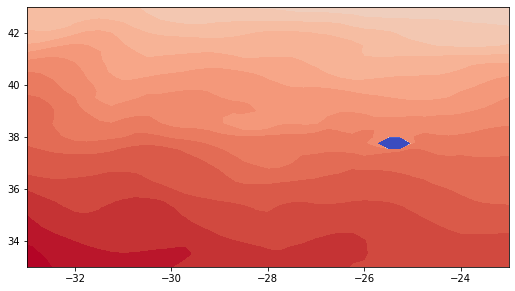

In [28]:
Visualization.visualization('./single_var_ERA5_meteo_sfc_2021_daily.nc','./only_sst.csv','../../data/coast.txt',['sst'])